In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train = pd.read_csv("Train_data.csv")
desc = pd.read_csv("Variable Description.csv")
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


## Data Cleaning

In [7]:
train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [4]:
from sklearn.impute import SimpleImputer

num_cols = train.select_dtypes(include=['int64','float64']).columns
cat_cols = train.select_dtypes(include=['object']).columns

train[num_cols] = SimpleImputer(strategy='median').fit_transform(train[num_cols])
train[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(train[cat_cols])

## Exploratory Data Analysis

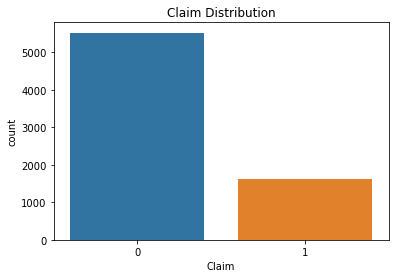

In [8]:
sns.countplot(x='Claim', data=train)
plt.title('Claim Distribution')
plt.show()

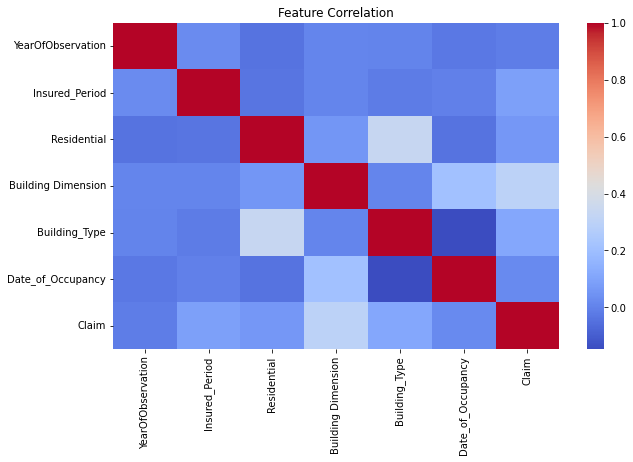

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [24]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [28]:
from sklearn.impute import SimpleImputer

num_cols = train.select_dtypes(include=['int64','float64']).columns
cat_cols = train.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

train[num_cols] = num_imputer.fit_transform(train[num_cols])
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Preprocessing for modelling 

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


X = train.drop('Claim', axis=1)
y = train['Claim']


preprocessor = ColumnTransformer(
transformers=[
('num', 'passthrough', num_cols.drop('Claim')),
('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
]
)

In [30]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

## Modelling

In [19]:
# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


log_model = Pipeline(steps=[
('preprocessor', preprocessor),
('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


log_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden',
       'Settlement', 'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier


rf_model = Pipeline(steps=[
('preprocessor', preprocessor),
('model', RandomForestClassifier(
n_estimators=200,
max_depth=10,
random_state=42,
class_weight='balanced'
))
])


rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden',
       'Settlement', 'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, random_state=42))])

In [ ]:
# Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier


gb_model = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier())
])


gb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden',
       'Settlement', 'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier())])

In [ ]:
# Model Evaluation

In [37]:
from sklearn.metrics import classification_report, roc_auc_score


models = {
    'Logistic Regression': log_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}


for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    print(name)
    print(classification_report(y_test, y_pred))
    print('ROC-AUC:', roc_auc_score(y_test, y_prob))
    print('-'*50)

Logistic Regression
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.81      1105
         1.0       0.39      0.50      0.44       327

    accuracy                           0.71      1432
   macro avg       0.62      0.64      0.62      1432
weighted avg       0.74      0.71      0.72      1432

ROC-AUC: 0.6739120207010114
--------------------------------------------------
Random Forest
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81      1105
         1.0       0.39      0.49      0.44       327

    accuracy                           0.71      1432
   macro avg       0.62      0.63      0.62      1432
weighted avg       0.74      0.71      0.72      1432

ROC-AUC: 0.6801624531252162
--------------------------------------------------
Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.87      1105
         1.0       0.61    